## The data is available as two attached CSV files:

takehome_user_engagement. csv

takehome_users . csv

### The data has the following two tables:

__1]__ A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:
- __name:__ the user's name
- __object_id:__ the user's id
- __email:__ email address
- __creation_source:__ how their account was created. This takes on one of 5 values:
  -  __PERSONAL_PROJECTS:__ invited to join another user's personal workspace
  - __GUEST_INVITE:__ invited to an organization as a guest (limited permissions)
  - __ORG_INVITE:__ invited to an organization (as a full member)
  - __SIGNUP:__ signed up via the website
  - __SIGNUP_GOOGLE_AUTH:__ signed up using Google Authentication (using a Google email account for their login id)

- __creation_time:__ when they created their account
- __last_session_creation_time:__ unix timestamp of last login
- __opted_in_to_mailing_list:__ whether they have opted into receiving marketing emails
- __enabled_for_marketing_drip:__ whether they are on the regular marketing email drip
- __org_id:__ the organization (group of users) they belong to
- __invited_by_user_id:__ which user invited them to join (if applicable).

__2]__ A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period , __identify which factors predict future user
adoption.__

We suggest spending 1­2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better ­­ no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [41]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
users = pd.read_csv("data/takehome_users.csv", encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
engagement = pd.read_csv("data/takehome_user_engagement.csv", encoding='latin-1')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Identify which factors predict future user adoption.
"Adopted user" : user who has logged into the product on three separate days in at least one seven-day period , 

### Discovering adoption events in the engagement log

In [4]:
# convert timestamp to datetime object
engagement["time_stamp"] = pd.to_datetime(engagement["time_stamp"])

# calculate each activity's adoption window as time + 7 days
engagement["plus_seven_days"] = engagement["time_stamp"] + timedelta(days=7)

# create empty list to hold week_activity counts
week_activity = []

# for each row, count the visits by the same user with a timestamp before the date plus 7 days
# append results to list
for i in range(len(engagement["time_stamp"])):
    week_activity.append(((engagement["time_stamp"] <= engagement["plus_seven_days"][i]) & (engagement["user_id"] == engagement["user_id"][i])).sum())

# convert list to series and add to dataframe
engagement["week_activity"] = pd.Series(week_activity)

# mark adoption events for weeks that have 3+ activities by the user
engagement["adoption"] = engagement["week_activity"] >= 3

In [5]:
engagement.head()

,time_stamp,user_id,visited,plus_seven_days,week_activity,adoption
0,2014-04-22 03:53:30,1,1,2014-04-29 03:53:30,1,False
1,2013-11-15 03:45:04,2,1,2013-11-22 03:45:04,1,False
2,2013-11-29 03:45:04,2,1,2013-12-06 03:45:04,2,False
3,2013-12-09 03:45:04,2,1,2013-12-16 03:45:04,3,True
4,2013-12-25 03:45:04,2,1,2014-01-01 03:45:04,5,True


Prepare user_engagement table for merging

In [6]:
user_engagement = engagement.groupby("user_id").sum().reset_index()
user_engagement["adoption"] = user_engagement["adoption"] >= 3
user_engagement.columns = ["user_id", "visits", "week_activity", "adoption"]
user_engagement = user_engagement.drop("week_activity", axis=1)
user_engagement["adoption"] = user_engagement["adoption"] + 0

In [7]:
user_engagement.head()

,user_id,visits,adoption
0,1,1,0
1,2,14,1
2,3,1,0
3,4,1,0
4,5,1,0


Merge user engagement data into the users table

In [8]:
# also fill blanks with 0. remember that invited by 0 means not invited
df = pd.merge(users, user_engagement, how="left", left_on="object_id", right_on="user_id").drop("user_id", axis=1).fillna(0)
df["creation_time"] = pd.to_datetime(df["creation_time"])
df["count"] = 1

In [9]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visits,adoption,count
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0,1


### Exploratory Analysis

In [10]:
adoption_by_month = df.set_index("creation_time")["adoption"].resample("M").sum() / df.set_index("creation_time")["count"].resample("M").sum() 

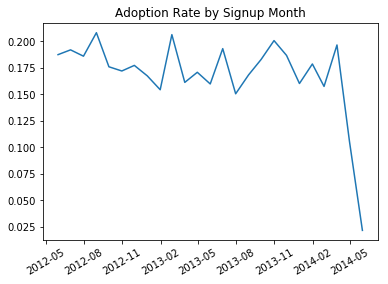

In [11]:
plt.plot(adoption_by_month)
plt.xticks(rotation='30')
plt.title("Adoption Rate by Signup Month")
plt.show()

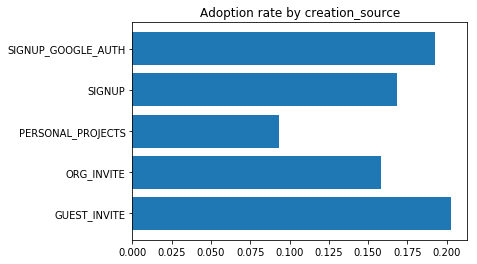

In [12]:
factor = "creation_source"

factor_df = df.groupby(factor).sum()["adoption"] / df.groupby(factor).sum()["count"]
plt.barh(width=factor_df, y=factor_df.index)
plt.title("Adoption rate by " + factor)
plt.show()

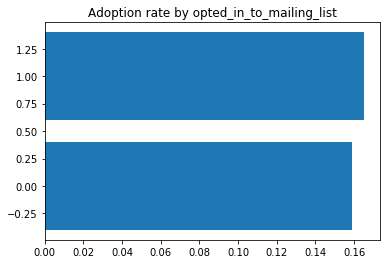

In [13]:
factor = "opted_in_to_mailing_list"

factor_df = df.groupby(factor).sum()["adoption"] / df.groupby(factor).sum()["count"]
plt.barh(width=factor_df, y=factor_df.index)
plt.title("Adoption rate by " + factor)
plt.show()

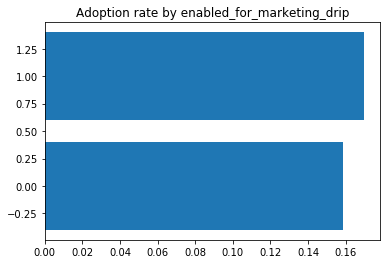

In [14]:
factor = "enabled_for_marketing_drip"

factor_df = df.groupby(factor).sum()["adoption"] / df.groupby(factor).sum()["count"]
plt.barh(width=factor_df, y=factor_df.index)
plt.title("Adoption rate by " + factor)
plt.show()

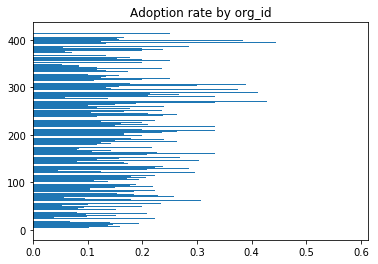

In [15]:
factor = "org_id"

factor_df = df.groupby(factor).sum()["adoption"] / df.groupby(factor).sum()["count"]
plt.barh(width=factor_df, y=factor_df.index)
plt.title("Adoption rate by " + factor)
plt.show()

In [16]:
import seaborn as sns

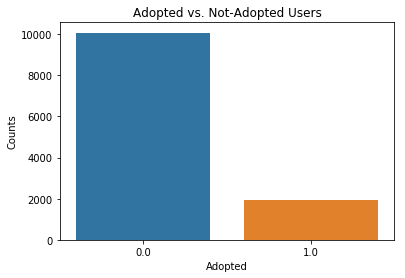

In [17]:
sns.countplot(x='adoption', data=df)
plt.title('Adopted vs. Not-Adopted Users')
plt.xlabel("Adopted")
plt.ylabel("Counts")
plt.xticks(rotation=0)
plt.show()

### Modeling

In [18]:
# Prepare the samples; convert categories into numerical values
samples = pd.get_dummies(df, columns = ['creation_source'], drop_first=False)
samples = samples.drop(["object_id", "name", "email", "last_session_creation_time", "creation_time", "visits", "count"], axis=1)

In [19]:
samples.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoption,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0.0,1,0,0,0,0
1,0,0,1,316.0,1.0,0,1,0,0,0
2,0,0,94,1525.0,0.0,0,1,0,0,0
3,0,0,1,5151.0,0.0,1,0,0,0,0
4,0,0,193,5240.0,0.0,1,0,0,0,0


In [23]:
sm = SMOTE(ratio='auto', kind='regular')
features, target = samples.drop("adoption", axis=1), samples["adoption"]
X, y = sm.fit_sample(features, target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)

In [30]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Score:", model.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Score: 0.5570776255707762
Classification Report:
             precision    recall  f1-score   support

        0.0       0.57      0.51      0.54      2533
        1.0       0.55      0.60      0.57      2504

avg / total       0.56      0.56      0.56      5037



In [33]:
model = RandomForestClassifier(class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Score:", model.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Score: 0.825292833035537
Classification Report:
             precision    recall  f1-score   support

        0.0       0.80      0.86      0.83      2533
        1.0       0.85      0.79      0.82      2504

avg / total       0.83      0.83      0.83      5037



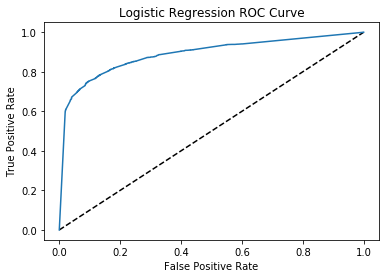

Area under curve: 0.888677523778772


In [40]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], "k--")
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()
print("Area under curve:", roc_auc_score(y_test, y_pred_prob))

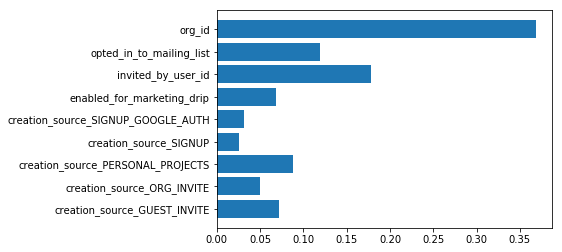

In [42]:
plt.barh(y= features.columns, width=model.feature_importances_)
plt.show()

### Conclusion

The top three predictive factors are the organization the user belongs to, whether they opted into the mailing list, and who it was that invited them. Users who sign up for personal projects will also adopt at higher rates, implying they do it because they want to, not because they have to.

The exploratory analysis was able to hint fairly accurately at what machine learning models would best benefit from using to predict adoption. Predicting the adoption was extremely inaccurate without using the SMOTE technique of oversampling, even with feature weighting by the models. Logistic regression was not useful as most of the features are binary categories. 

Further work could be done to optimize the model, though it would likely not rearrange feature importances. 